# Fine-tune Open-Source LLMs on Nebius Token Factory

Learn how to fine-tune & deploy open models like Llama 3.1 directly from your dataset using [Nebius Token Factory](https://tokenfactory.nebius.com/), an all-in-one platform for working with large language models (LLMs).

Before you begin, get your API key from the [Dashboard](https://tokenfactory.nebius.com/?modals=create-api-key).

You can run this notebook on Google Colab (without setting up any python env!) or locally.

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/nebius/token-factory-cookbook/blob/main/post-training/fine-tuning-1/fine_tune_llama.ipynb)

## Step-1: Fine Tuning Configuration

Pick models to fine tune

In [ ]:
## Pick a model to fine-tune
# note slight name variations for models
BASE_MODEL_FINETUNE = "meta-llama/Llama-3.1-8B-Instruct"
BASE_MODEL_INFERENCE = 'meta-llama/Meta-Llama-3.1-8B-Instruct'

# BASE_MODEL_FINETUNE = "unsloth/gpt-oss-20b-BF16"
# BASE_MODEL_INFERENCE = "openai/gpt-oss-20b"

## Data dir - for temp data (not checked into git)
DATA_DIR = 'data'

## Fine tuning parameters
EPOCHS = 5
BATCH_SIZE = 32
LEARNING_RATE = 2e-5


## Step 2: Installation & Setup

In [ ]:
## Determine runtime
import os

if os.getenv("COLAB_RELEASE_TAG"):
   print("Running on Colab")
   RUNNING_ON_COLAB = True
else:
   print("NOT running on Colab")
   RUNNING_ON_COLAB = False

NOT running on Colab


In [ ]:
if RUNNING_ON_COLAB:
    !pip install -qq openai datasets python-dotenv  pandas jinja2

## Step 3: Load Configuration

In [ ]:
import os, sys

## Recommended way of getting configuration
if RUNNING_ON_COLAB:
   from google.colab import userdata
   NEBIUS_API_KEY = userdata.get('NEBIUS_API_KEY')
else:
   from dotenv import load_dotenv
   this_dir = os.path.abspath('')
   parent_dir = os.path.dirname(this_dir)
   sys.path.append (os.path.abspath (parent_dir))
   load_dotenv()
   NEBIUS_API_KEY = os.getenv('NEBIUS_API_KEY')

## quick hack (not recommended) - you can hardcode the config key here
# NEBIUS_API_KEY = "your_key_here"

if NEBIUS_API_KEY:
  print ('✅ NEBIUS_API_KEY found')
  os.environ['NEBIUS_API_KEY'] = NEBIUS_API_KEY
else:
  raise RuntimeError ('❌ NEBIUS_API_KEY NOT found')

✅ NEBIUS_API_KEY found


In [ ]:
## Extra configs

API_URL = 'https://api.tokenfactory.nebius.com'

## Step-4: Initialize Client

In [ ]:
from openai import OpenAI

client = OpenAI(
    base_url=f"{API_URL}/v1/",
    api_key=os.getenv('NEBIUS_API_KEY'),
)

Before running, store your key in Colab Variables as `NEBIUS_API_KEY` or export it as an environment variable.





## Step 5: Prepare your dataset

### 5.1 - Load data

Fine-tuning works best with conversational data (the OpenAI-style format with messages).
We’ll use a sample [dataset](https://huggingface.co/datasets/olathepavilion/Conversational-datasets-json)  from Hugging Face to keep things simple.

You can learn more about preparing DataSets [here](https://docs.tokenfactory.nebius.com/fine-tuning/datasets)

In [ ]:
from datasets import load_dataset

dataset = load_dataset("olathepavilion/Conversational-datasets-json", split='train')

dataset

/Users/sujee/my-stuff/nebius/token-factory-cookbook-worktree/fine-tuning-1/post-training/fine-tuning-1/.venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Dataset({
    features: ['messages'],
    num_rows: 1000
})

### 5.2 - Examine data


In [ ]:
import json

for i in range(2):
    print(json.dumps(dataset[i]['messages'], indent=2))
    print("\n---\n")

[
  {
    "role": "system",
    "content": "Star is a friendly chatbot companion ready to engage in everyday role-playing\u00a0conversations."
  },
  {
    "role": "user",
    "content": "Happy birthday, Lillian. Here's a little present I bought for you."
  },
  {
    "role": "assistant",
    "content": "Thank you, Paul."
  }
]

---

[
  {
    "role": "system",
    "content": "Star is a friendly chatbot companion ready to engage in everyday role-playing\u00a0conversations."
  },
  {
    "role": "user",
    "content": "Hi Isabel! You wanted to see me?"
  },
  {
    "role": "assistant",
    "content": "Yes Anthony, come on in. Have a seat."
  },
  {
    "role": "user",
    "content": "Is everything okay? You seem a bit preoccupied."
  },
  {
    "role": "assistant",
    "content": "Well, Anthony, this is not going to be an easy conversation.The company has made some decisions which will have a direct impact on your employment."
  },
  {
    "role": "user",
    "content": "Okay..."
  },
 

### 5.3 - Create train / validate datasets

In [ ]:
## cleanup data dir
import shutil
if os.path.exists (DATA_DIR):
    shutil.rmtree (DATA_DIR)
os.makedirs (DATA_DIR, exist_ok=True)

In [ ]:
import json
import os

# split into 2 sets
dataset_split = dataset.train_test_split(test_size=0.2, seed=42, shuffle=False)

dataset_train = dataset_split['train']
dataset_validation = dataset_split['test']

print (dataset_split)

train_data_formatted = [{"messages": entry["messages"]} for entry in dataset_train]
validation_data_formatted = [{"messages": entry["messages"]} for entry in dataset_validation]

train_data_path = os.path.join(DATA_DIR, "training_data.jsonl")
with open(train_data_path, "w", encoding="utf-8") as f:
    for ex in train_data_formatted:
        f.write(json.dumps(ex, ensure_ascii=False) + "\n")
print(f"Saved {len(train_data_formatted)} samples to {train_data_path}")


validation_data_path = os.path.join(DATA_DIR, "validation_data.jsonl")
with open(validation_data_path, "w", encoding="utf-8") as f:
    for ex in validation_data_formatted:
        f.write(json.dumps(ex, ensure_ascii=False) + "\n")

print(f"Saved {len(validation_data_formatted)} samples to {validation_data_path}")


DatasetDict({
    train: Dataset({
        features: ['messages'],
        num_rows: 800
    })
    test: Dataset({
        features: ['messages'],
        num_rows: 200
    })
})
Saved 800 samples to data/training_data.jsonl
Saved 200 samples to data/validation_data.jsonl


## Step 6: Upload your dataset to Token Factory

Next, we’ll upload the dataset so Nebius can access it for training.

In [ ]:
fine_tuning_train_file = client.files.create(
    file=open(train_data_path, "rb"),
    purpose="fine-tune"
)
fine_tuning_train_file

FileObject(id='file-019b0be3-b432-7392-8f07-9d714bc23224', bytes=657543, created_at=1765431030, filename='training_data.jsonl', object='file', purpose='fine-tune', status=None, expires_at=None, status_details=None)

In [ ]:
fine_tuning_validation_file = client.files.create(
    file=open(validation_data_path, "rb"),
    purpose="fine-tune"
)
fine_tuning_validation_file

FileObject(id='file-019b0be3-bfc8-7a03-9796-fba7337b9301', bytes=184319, created_at=1765431033, filename='validation_data.jsonl', object='file', purpose='fine-tune', status=None, expires_at=None, status_details=None)

## Step 7: Create and start your fine-tuning job

We’ll fine-tune Llama 3.2 1B Instruct using LoRA, which is efficient and much faster than full fine-tuning.

In [ ]:
job = client.fine_tuning.jobs.create(
    model= BASE_MODEL_FINETUNE,
    suffix="demo-run",
    training_file=fine_tuning_train_file.id,
    validation_file = fine_tuning_validation_file.id,
    hyperparameters={
        "batch_size": BATCH_SIZE,
        "learning_rate_multiplier": LEARNING_RATE,
        "n_epochs": EPOCHS,
        "warmup_ratio": 0.03,
        "weight_decay": 0,
        "lora": True,
        "packing": True,
    },
)

print("Job created:", job.id, "| status:", job.status)

Job created: ftjob-49b4625687fe42d1a981c9f9bbdfd569 | status: running


## Step 8: Monitor job progress

When you create a fine-tune job, its initial status will usually be running.
The script below polls the status every 15 seconds to check for updates.

If it fails, Nebius will return an error message explaining what went wrong, and how to fix it. If you get a 500 error, just resubmit the job.

The training is complete when you see either Dataset processed successfully or Training completed successfully in the event logs.

In [ ]:
%%time
import time

start_time = time.time()
update_num_seconds = 30
active_statuses = ["validating_files", "queued", "running"]
print (f"Fine tuning job {job.id} created, waiting for completion...")

while job.status in active_statuses:
    time.sleep(update_num_seconds)
    job = client.fine_tuning.jobs.retrieve(job.id)
    elapsed = time.time() - start_time
    print(f"Elapsed: {int(elapsed)}s ({elapsed/60:.1f} min) : current status: {job.status}")

print("Final status:", job.status)


Fine tuning job ftjob-49b4625687fe42d1a981c9f9bbdfd569 created, waiting for completion...
Elapsed: 30s (0.5 min) : current status: running
Elapsed: 61s (1.0 min) : current status: running
Elapsed: 92s (1.5 min) : current status: running
Elapsed: 122s (2.0 min) : current status: running
Elapsed: 153s (2.6 min) : current status: running
Elapsed: 183s (3.1 min) : current status: running
Elapsed: 213s (3.6 min) : current status: running
Elapsed: 244s (4.1 min) : current status: running
Elapsed: 274s (4.6 min) : current status: running
Elapsed: 305s (5.1 min) : current status: succeeded
Final status: succeeded
CPU times: user 99.6 ms, sys: 38.1 ms, total: 138 ms
Wall time: 5min 5s


Check job events:

In [ ]:
events = client.fine_tuning.jobs.list_events(job.id)
for e in events.data:
    print(f"[{e.created_at}] {e.level}: {e.message}")

[1765431035] info: Job is submitted
[1765431063] info: Dataset 'validation' processed successfully
[1765431065] info: Dataset 'training' processed successfully
[1765431268] info: Training completed successfully


## Step-9: Inspect training job

Examine loss over epochs

In [ ]:
import pandas as pd

ft_checkpoints = client.fine_tuning.jobs.checkpoints.list(job.id).data
metrics = []
for epoch_data in ft_checkpoints:
    epoch_metrics = {}
    epoch_metrics["train_loss"] = epoch_data.metrics.train_loss
    epoch_metrics["valid_loss"] = epoch_data.metrics.valid_loss
    metrics.append(epoch_metrics)

df_metrics = pd.DataFrame(metrics)
df_metrics.index = df_metrics.index + 1
df_metrics.style.background_gradient(cmap='Reds')

,train_loss,valid_loss
1,3.363983,3.284986
2,3.364883,2.765526
3,3.316328,2.397027
4,3.234269,2.289490
5,3.147930,2.252911


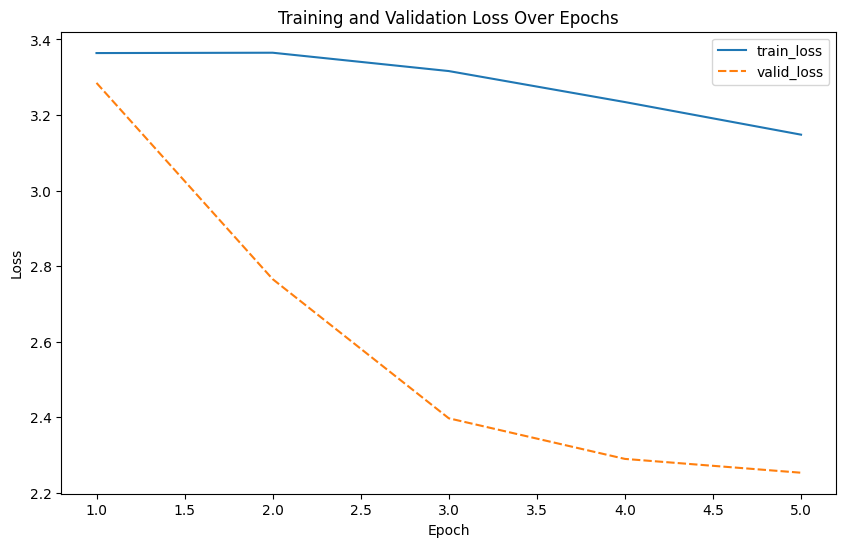

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10, 6))
sns.lineplot(data=df_metrics[['train_loss', 'valid_loss']])
plt.title('Training and Validation Loss Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()

### Step 8: Download your checkpoints

After every epoch, Nebius saves a checkpoint, a snapshot of the model at that stage. You’ll get all of them. For the final model, just grab the last checkpoint.

The code below creates a folder for each checkpoint and saves all the files there.

In [ ]:
# ## This code saves all checkpoints

# if job.status == "succeeded":
#     # Check the job events
#     events = client.fine_tuning.jobs.list_events(job.id)
#     print(events)

#     for checkpoint in client.fine_tuning.jobs.checkpoints.list(job.id).data:
#         print("Checkpoint ID:", checkpoint.id)

#         # Create a directory for every checkpoint
#         os.makedirs(checkpoint.id, exist_ok=True)

#         for model_file_id in checkpoint.result_files:
#             # Get the name of a model file
#             filename = client.files.retrieve(model_file_id).filename

#             # Retrieve the contents of the file
#             file_content = client.files.content(model_file_id)

#             # Save the contents into a local file
#             file_content.write_to_file(filename)

In [ ]:
## Save the last checkpoint

import shutil

save_dir = "model-checkpoints/latest"
shutil.rmtree(save_dir, ignore_errors=True)
os.makedirs(save_dir, exist_ok=True)

n_selected_epoch = -1
best_checkpoint = ft_checkpoints[n_selected_epoch]

for model_file_id in best_checkpoint.result_files:
    # Get the name of the file
    file_name = client.files.retrieve(model_file_id).filename.split('/')[1]
    # Retrieve the contents of the file
    file_content = client.files.content(model_file_id)
    # Save the file
    file_content.write_to_file(os.path.join(save_dir, file_name))

## Step-8: How much did our training cost?


The price for fine-tuning a model under 20B parameters is \$0.4/1M tokens. Let's calculate the total fine-tuning price.

Check the [pricing guide](https://nebius.com/token-factory/prices)

In [ ]:
price = job.trained_tokens * 0.4 / 1_000_000
print(f'Fine-tuning price: ${price:.1f}')

Fine-tuning price: $0.5


## Setp 9: Deploy Your LoRA Adapter

Now that your fine-tune is complete, you can deploy the **LoRA adapter** directly on **Nebius Token Factory** for inference.  
This lets you use your fine-tuned model as a hosted endpoint, ready for API calls, experiments, or integration into your own applications.

In [ ]:
import requests

lora_creation_request = {
    "name": "my-finetuned-model",  # You can set whatever name you like
    "base_model": BASE_MODEL_INFERENCE,
    "source": f"{job.id}:{best_checkpoint.id}",
    "description": "Fine tuned model"
}


url = f"{API_URL}/v0/models"

response = requests.post(
    url,
    json=lora_creation_request,
    headers={
        "Content-Type": "application/json",
        "Authorization": f"Bearer {os.getenv('NEBIUS_API_KEY')}"
    }
)
response_json = response.json()

response_json

{'name': 'meta-llama/Meta-Llama-3.1-8B-Instruct-LoRa:my-finetuned-model-JuNN',
 'base_model': 'meta-llama/Meta-Llama-3.1-8B-Instruct',
 'source': 'ftjob-49b4625687fe42d1a981c9f9bbdfd569:ftckpt_98a07a09-9fb7-4009-8e18-0f72beade81c',
 'description': 'Fine tuned model',
 'created_at': 1765431401,
 'status': 'validating'}

In [ ]:
deployed_model_name = response_json["name"]

print ('deployed model name:', deployed_model_name)

deployed model name: meta-llama/Meta-Llama-3.1-8B-Instruct-LoRa:my-finetuned-model-JuNN


In [ ]:
# # Wait for validation of the deployed model
def wait_for_validation(model_name, delay=5):
    print(f"Waiting for validation of LoRA model '{model_name}'...")
    while True:
        time.sleep(delay)
        lora_info = requests.get(
            f"{API_URL}/v0/models/{model_name}",
            headers={
                "Content-Type": "application/json",
                "Authorization": f"Bearer {os.getenv('NEBIUS_API_KEY')}"
            }
        ).json()
        current_status = lora_info.get("status", "unknown")
        print(f"Current status for '{model_name}': {current_status}")
        if current_status in {"active", "error"}:
            return lora_info

print (wait_for_validation(deployed_model_name))

Waiting for validation of LoRA model 'meta-llama/Meta-Llama-3.1-8B-Instruct-LoRa:my-finetuned-model-JuNN'...
Current status for 'meta-llama/Meta-Llama-3.1-8B-Instruct-LoRa:my-finetuned-model-JuNN': unknown
Current status for 'meta-llama/Meta-Llama-3.1-8B-Instruct-LoRa:my-finetuned-model-JuNN': active
{'type': 'text2text', 'name': 'meta-llama/Meta-Llama-3.1-8B-Instruct-LoRa:my-finetuned-model-JuNN', 'status': 'active', 'status_reason': None, 'checkpoint_id': 'ftckpt_98a07a09-9fb7-4009-8e18-0f72beade81c', 'job_id': 'ftjob-49b4625687fe42d1a981c9f9bbdfd569', 'file_id': None, 'url': None, 'created_at': 1765431401, 'description': 'Fine tuned model', 'vendor': 'meta', 'tags': ['128K context', 'small', 'JSON mode', 'lora'], 'use_cases': ['lora'], 'quality': 73, 'context_window_k': 128, 'size_b': 8.03}


In [ ]:
# import requests, time

# # api_url = "https://api.tokenfactory.nebius.com"
# # base_model = "meta-llama/Meta-Llama-3.1-8B-Instruct"

# # Create a LoRA model from a fine-tuning job and checkpoint
# def create_lora_from_job(name, ft_job, ft_checkpoint, base_model):
#     print(f"Creating LoRA model from job {ft_job} and checkpoint {ft_checkpoint}...")
#     fine_tuning_result = ft_job + ":" + ft_checkpoint
#     lora_creation_request = {
#         "source": fine_tuning_result,
#         "base_model": BASE_MODEL_INFERENCE,
#         "name": name,
#         "description": "Example LoRA model deployment"
#     }
#     response = requests.post(
#         f"{API_URL}/v0/models",
#         json=lora_creation_request,
#         headers={
#             "Content-Type": "application/json",
#             "Authorization": f"Bearer  {os.getenv('NEBIUS_API_KEY')}"
#         }
#     )
#     print(f"LoRA model creation request sent. Response: {response.json()}")
#     return response.json()

# # Wait for validation of the deployed model
# def wait_for_validation(name, delay=5):
#     print(f"Waiting for validation of LoRA model '{name}'...")
#     while True:
#         time.sleep(delay)
#         lora_info = requests.get(
#             f"{API_URL}/v0/models/{name}",
#             headers={
#                 "Content-Type": "application/json",
#                 "Authorization": f"Bearer {os.getenv('NEBIUS_API_KEY')}"
#             }
#         ).json()
#         current_status = lora_info.get("status", "unknown")
#         print(f"Current status for '{name}': {current_status}")
#         if current_status in {"active", "error"}:
#             return lora_info

# # Send a test completion request
# def get_completion(model):
#     print(f"Requesting completion from model '{model}'...")
#     completion = client.chat.completions.create(
#         model=model,
#         messages=[{"role": "user", "content": "Hello"}],
#     )
#     print(f"Completion received for model '{model}'.")
#     return completion.choices[0].message.content

# # Deploy a LoRA adapter model using the fine-tuning job and checkpoint IDs
# lora_name = create_lora_from_job("demo", job.id, best_checkpoint.id, BASE_MODEL_FINETUNE).get("name")
# print(f"Generated LoRA model name: {lora_name}")

# # Check model validation status
# lora_info = wait_for_validation(lora_name)

# # If validation passes, test inference
# if lora_info.get("status") == "active":
#     print(f"LoRA model '{lora_name}' is active. Getting a sample completion...")
#     print(get_completion(lora_name))
# elif lora_info.get("status") == "error":
#     print(f"An error occurred during validation: {lora_info['status_reason']}")

## Step-10: Test the newly deployed model

Once the model status becomes active, you can send chat completions just like any OpenAI-compatible model.

In [ ]:
import os
from openai import OpenAI

client = OpenAI(
  base_url=f"{API_URL}/v1/",
    api_key=os.getenv('NEBIUS_API_KEY'),
)

response = client.chat.completions.create(
    model=deployed_model_name,
    messages=[
        {
            "role": "system",
            "content": "You are helpful assistant"
        },
        {
            "role": "user",
            "content": [
                {
                    "type": "text",
                    "text": "Hello! "
                }
            ]
        }
    ]
)

print(response.to_json())


{
  "id": "chatcmpl-649d3439e2094d8384ab2e941c408aff",
  "choices": [
    {
      "finish_reason": "stop",
      "index": 0,
      "logprobs": null,
      "message": {
        "content": "Hello",
        "refusal": null,
        "role": "assistant",
        "annotations": null,
        "audio": null,
        "function_call": null,
        "tool_calls": [],
        "reasoning_content": null
      },
      "stop_reason": null
    }
  ],
  "created": 1765431413,
  "model": "meta-llama/Meta-Llama-3.1-8B-Instruct-LoRa:my-finetuned-model-JuNN",
  "object": "chat.completion",
  "service_tier": null,
  "system_fingerprint": null,
  "usage": {
    "completion_tokens": 2,
    "prompt_tokens": 41,
    "total_tokens": 43,
    "completion_tokens_details": null,
    "prompt_tokens_details": null
  },
  "prompt_logprobs": null
}


## DONE!

And that’s it!

You’ve just fine-tuned, deployed, and run inference with your own LoRA model, all using Nebius Token Factory.

If you want to go further, here are a few next steps worth exploring:

- [Track Fine-Tuning Jobs](https://tokenfactory.nebius.com/fine-tuning): Monitor progress, view logs, and check model checkpoints  
- [Deploy Your Custom Model](https://docs.tokenfactory.nebius.com/fine-tuning/deploy-custom-model): Set up inference endpoints and integrate your fine-tuned model into applications  
- [Fine-Tuning Docs](https://docs.tokenfactory.nebius.com/fine-tuning/overview): Learn about hyperparameters, LoRA configurations, and advanced options  
- [Nebius Token Factory Dashboard](https://tokenfactory.nebius.com/): Manage models, datasets, and deployments visually  

**Start tracking and deploying your fine-tuned models today at [Nebius Token Factory](https://tokenfactory.nebius.com/).**
